This notebook performs the synthesis using our proposed synthesization approach applied to the IPUMS data. The synthesis model is a CART. Logistic regression with three way interactions is used as the pMSE model.

In [1]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools
import pickle

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

Need to figure out how we are handling the `years_of_educ` and `potential_experience` variables. Probably need to synthesize using proper categorical models. This might require converting to a category here at the beginning of the file and then converting back to the original values at the end, but this will affect the computation of the pMSE ratio. Another option is to remove the decimal portions from the observations that have them so that it is not treated as a continuous variable by default.

In [2]:
# import standardized lat/long location data
train_data = pd.read_csv("../Data/IPUMS/cleaned_ipums_data.csv")

In [3]:
train_data

,incwage,years_of_educ,potential_experience,non_white,sex
0,-0.579435,1.109071,-0.039398,0,1
1,0.564281,0.724424,0.369388,0,0
2,-0.748874,-0.044869,-1.347515,0,0
3,-0.935257,-0.814163,-1.511030,0,0
4,-0.164308,-0.429516,1.186962,1,0
...,...,...,...,...,...
197751,-0.092296,1.109071,-0.448185,0,0
197752,-0.854774,1.109071,-0.611699,0,1
197753,0.521921,1.777461,0.063806,0,0
197754,-0.981853,0.724424,-0.448185,0,1


***

Functions for logistic and multinomial logistic regression synthesizer.

In [4]:
def train_models_mn(#overall parameters
                    train_data,
                    number_synthetic_datasets,
                    # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                    number_gmm_initializations,
                    num_components_,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_non_white_,
                    C_sex_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, covariance_type='full', init_params="k-means++", random_state=rng).fit(train_data.loc[:,["incwage", "years_of_educ", "potential_experience"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ["incwage", "years_of_educ", "potential_experience"]
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for non-white MN ##########
    
    synth_non_white_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["incwage", "years_of_educ", "potential_experience"]], 
                                                   synth_data_sets=sXs, 
                                                   target=train_data.non_white, 
                                                   penalty_param=C_non_white_)
    
    sXs = [pd.concat([Y, synth_non_white_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ########### Code for sex MN ##########
    
    synth_sex_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["incwage", "years_of_educ", "potential_experience", "non_white"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.sex, 
                                             penalty_param=C_sex_)
    
    sXs = [pd.concat([Y, synth_sex_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs, GMM

In [5]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       number_gmm_initializations,
                       random_state):

    def evaluate_models(num_components_, C_non_white_, C_sex_):

        pmse_ratios, _, _ = train_models_mn(train_data=train_data,
                                            number_synthetic_datasets=number_synthetic_datasets,
                                            number_gmm_initializations=number_gmm_initializations,
                                            num_components_=int(num_components_),
                                            C_non_white_=C_non_white_,
                                            C_sex_=C_sex_)
        
        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "C_non_white_": (0.001, 3),
            "C_sex_": (0.001, 3)
        },
        random_state=random_state)
    
    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value for $\alpha = 1e-06$.

In [6]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [7]:
optimization_results = [optimize_models_mn(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   | C_non_... |  C_sex_   | num_co... |
-------------------------------------------------------------
| 1         | -0.05209  | 2.23      | 0.68      | 132.7     |
| 2         | -0.1764   | 2.647     | 2.222     | 147.8     |
| 3         | -579.7    | 0.8867    | 1.577     | 43.19     |
| 4         | -0.9594   | 2.436     | 2.548     | 58.99     |
| 5         | -72.98    | 0.7125    | 1.376     | 53.72     |
| 6         | -0.04485  | 2.438     | 1.451     | 140.2     |
| 7         | -205.3    | 0.001     | 0.001     | 68.64     |
| 8         | -192.0    | 0.001     | 0.001     | 156.6     |
| 9         | -12.88    | 0.001     | 3.0       | 125.5     |
| 10        | -0.000215 | 0.08589   | 2.939     | 143.9     |
| 11        | -65.03    | 3.0       | 0.001     | 114.7     |
| 12        | -0.02396  | 3.0       | 3.0       | 201.0     |
| 13        | -194.3    | 0.001     | 0.001     | 193.1     |
| 14        | -100.5    | 3.0       | 0.001     | 144.5     |
| 15    

In [11]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

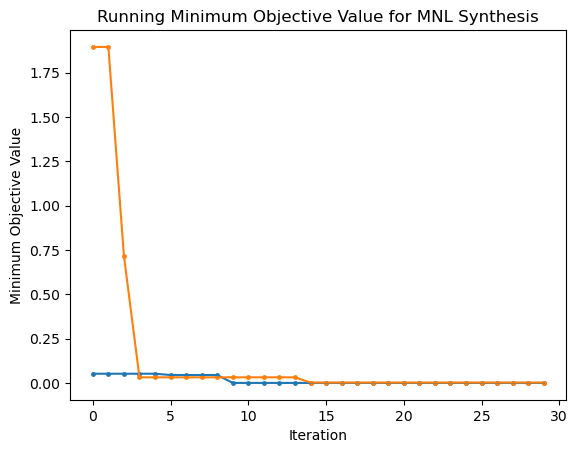

In [12]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Running Minimum Objective Value for MNL Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [13]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [14]:
best_params

{'target': -0.00021527796061185814,
 'params': {'C_non_white_': 0.0858919431389487,
  'C_sex_': 2.938956741896849,
  'num_components_': 143.85248994180307}}

Generate 20 synthetic data sets.

On occassion, the synthesis models will produce a significantly different fit than what was observed during the optimization process. In these cases, retrain the models until a fit (judged by the pMSE ratio) consistent with the optimization results is observed.

In [21]:
pmse_ratios, full_sXs, GMM = train_models_mn(train_data=train_data,
                                             number_synthetic_datasets=20,
                                             # hyperparameters for GMM
                                             number_gmm_initializations=ngi,
                                             num_components_=int(best_params['params']['num_components_']),
                                             # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                             C_non_white_=best_params['params']['C_non_white_'],
                                             C_sex_=best_params['params']['C_sex_'])

In [22]:
np.mean(pmse_ratios)

0.9387406749219978

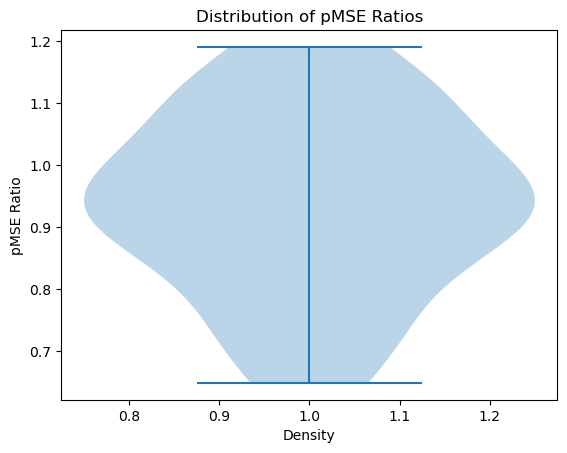

In [23]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

# Save the synthetic datasets.

Save the GMM model.

In [24]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv", index=False)

# save
with open('../Results/IPUMS/Models/gmm_and_mnl.pkl','wb') as f:
    pickle.dump(GMM,f)

In [ ]:
full_sXs = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]

# load
with open('../Results/IPUMS/Models/gmm_and_mnl.pkl', 'rb') as f:
    GMM = pickle.load(f)

***

Now apply the attribute disclosure prevention algorithm.

We don't have a great baseline for the probability of being non-white, so we'll just use the proportion from the data.

In [ ]:
prior = np.mean(train_data.non_white == 1)

In [ ]:
prior

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the non-white status based on the synthetic data. This is a relatively large increase. For example, this means going from XXX under the prior to no more than XXX under the updated probability.

In [ ]:
c = 3

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [ ]:
deltas = np.linspace(0.001, 0.1, 3)

In [ ]:
ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
                                         synthetic_data=X,
                                         continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
                                         categorical_vars=['sex'],
                                         sensitive_var='non_white',
                                         mixture_model=GMM,
                                         deltas=deltas, 
                                         c=c, 
                                         prior_prob=prior) for X in full_sXs]

In [ ]:
for i, sX in enumerate(ad_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/ad_gmm_and_mnl_" + str(i) + ".csv", index=False)